🔹 Loading dataset...
✅ Data loaded: (56661, 78)
✅ Final training sample: (6311, 78)
✅ Data ready for training: (12208, 77)

🔹 Training models...
✅ DT trained.
✅ RF trained.
✅ ET trained.
✅ XGB trained.
✅ Stacking meta-model trained.

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

      BENIGN       0.95      0.84      0.89        45
      Botnet       0.99      1.00      0.99       393
  BruteForce       0.99      1.00      1.00       111
         DoS       0.99      0.99      0.99       191
Infiltration       1.00      0.86      0.92         7
    PortScan       1.00      1.00      1.00        80
   WebAttack       1.00      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.99      0.96      0.97      1263
weighted avg       0.99      0.99      0.99      1263



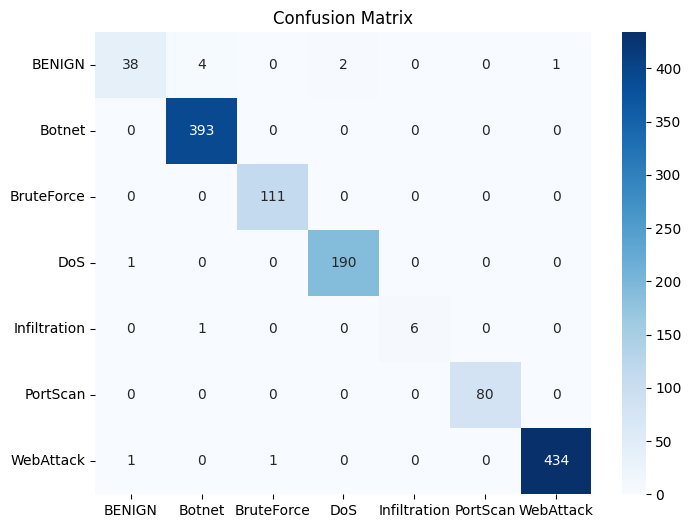


✅ ALL MODELS SAVED SUCCESSFULLY IN 'models' FOLDER.
🔥 PHASE 1 COMPLETE: Multi-class IDS Model Ready for IPS Integration.


In [6]:
# --- IS_IDS_1_FINAL.ipynb ---
# ✅ Enhanced Intrusion Detection Model (Multi-class) for IPS Integration

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import joblib, os, warnings
warnings.filterwarnings("ignore")

# --- 1. SETUP ---
FLOW_FEATURE_NAMES = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
    'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min',
    'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
    'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
    'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
    'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
    'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
    'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
    'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
    'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
    'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count',
    'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
    'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size',
    'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1',
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
    'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
    'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std',
    'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max',
    'Idle Min'
]

# --- 2. DATA LOADING ---
print("🔹 Loading dataset...")
df = pd.read_csv(r'CICIDS2017_sample.csv')

print("✅ Data loaded:", df.shape)

# --- 3. CLEAN & MAP LABELS ---
def simplify_label(label):
    if "DoS" in label or "DDOS" in label: return "DoS"
    elif "PortScan" in label: return "PortScan"
    elif "BruteForce" in label: return "BruteForce"
    elif "WebAttack" in label: return "WebAttack"
    elif "Bot" in label: return "Botnet"
    elif "Infiltration" in label: return "Infiltration"
    elif "Heartbleed" in label: return "Heartbleed"
    else: return "BENIGN"

df["Label"] = df["Label"].apply(simplify_label)

# --- 4. SAMPLING ---
df_minor = df[df['Label'].isin(['WebAttack', 'Botnet', 'Infiltration', 'Heartbleed'])]
df_BENIGN = df[df['Label']=='BENIGN'].sample(frac=0.01, random_state=42)
df_DoS = df[df['Label']=='DoS'].sample(frac=0.05, random_state=42)
df_PortScan = df[df['Label']=='PortScan'].sample(frac=0.05, random_state=42)
df_BruteForce = df[df['Label']=='BruteForce'].sample(frac=0.2, random_state=42)

df_balanced = pd.concat([df_BENIGN, df_DoS, df_PortScan, df_BruteForce, df_minor])
print("✅ Final training sample:", df_balanced.shape)

# --- 5. FEATURES & LABELS ---
X = df_balanced.drop(['Label'], axis=1)
y = df_balanced['Label']

# Fix invalid values
X.replace([np.inf, -np.inf], 0.0, inplace=True)
X.fillna(0.0, inplace=True)

# Encode labels
labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y_encoded, train_size=0.8, test_size=0.2,
    random_state=42, stratify=y_encoded
)

# Scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("✅ Data ready for training:", X_train.shape)

# --- 6. BASE MODELS ---
print("\n🔹 Training models...")
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
et = ExtraTreesClassifier(n_estimators=100, random_state=42)
xg = xgb.XGBClassifier(n_estimators=50, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')

for model, name in zip([dt, rf, et, xg], ["DT", "RF", "ET", "XGB"]):
    model.fit(X_train, y_train)
    print(f"✅ {name} trained.")

# --- 7. STACKING META-MODEL ---
train_preds = np.column_stack([
    dt.predict(X_train),
    rf.predict(X_train),
    et.predict(X_train),
    xg.predict(X_train)
])
test_preds = np.column_stack([
    dt.predict(X_test),
    rf.predict(X_test),
    et.predict(X_test),
    xg.predict(X_test)
])

stk = GradientBoostingClassifier(random_state=42)
stk.fit(train_preds, y_train)
print("✅ Stacking meta-model trained.")

# --- 8. EVALUATION ---
final_preds = stk.predict(test_preds)
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, final_preds, target_names=labelencoder.classes_))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, cmap="Blues", fmt="d",
            xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_)
plt.title("Confusion Matrix")
plt.show()

# --- 9. SAVE COMPONENTS ---
SAVE_DIR = './models'
os.makedirs(SAVE_DIR, exist_ok=True)

joblib.dump(scaler, os.path.join(SAVE_DIR, 'ids_scaler.joblib'))
joblib.dump(stk, os.path.join(SAVE_DIR, 'ids_stacking_model.joblib'))
joblib.dump(dt, os.path.join(SAVE_DIR, 'dt_model.joblib'))
joblib.dump(rf, os.path.join(SAVE_DIR, 'rf_model.joblib'))
joblib.dump(et, os.path.join(SAVE_DIR, 'et_model.joblib'))
joblib.dump(xg, os.path.join(SAVE_DIR, 'xg_model.joblib'))
joblib.dump(labelencoder, os.path.join(SAVE_DIR, 'label_encoder.joblib'))
joblib.dump(FLOW_FEATURE_NAMES, os.path.join(SAVE_DIR, 'flow_features.joblib'))

print("\n✅ ALL MODELS SAVED SUCCESSFULLY IN 'models' FOLDER.")
print("🔥 PHASE 1 COMPLETE: Multi-class IDS Model Ready for IPS Integration.")


In [ ]:
# pip install xgboost scikit-learn imbalanced-learn joblib

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 4.2 MB/s eta 0:00:14
   ---------------------------------------- 0.5/56.8 MB 4.2 MB/s eta 0:00:14
    --------------------------------------- 1.0/56.8 MB 2.4 MB/s eta 0:00:24
   - -------------------------------------- 1.6/56.8 MB 2.5 MB/s eta 0:00:23
   - -------------------------------------- 2.6/56.8 MB 2.7 MB/s eta 0:00:21
   -- ------------------------------------- 3.4/56.8 MB 3.1 MB/s eta 0:00:18
   -- ------------------------------------- 3.9/56.8 MB 2.9 MB/s eta 0:00:19
   -- ------------------------------------- 4.2/56.8 MB 2.6 MB/s eta 0:00:21
   -- ------------------------------------- 4.2/56.8 MB 2.6 MB/s eta 0:00:21
   -- ------------------------------------- 4.2/56.8 MB 2.6 MB/s eta 0:00:21
   -- ------------------------------------- 4.2/56.8 MB 2.6 MB/s eta 0:00:21
   -- ------------------------------------- 4.2/56.8 MB 2.6 MB/s eta 0:00:21
   ---